In [1]:
import os, re, json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 경로
SWEEP_DIR  = r"C:\dynamic_wirye_drt\outputs\run_sweep"
RESULT_DIR = r"C:\dynamic_wirye_drt\results"
PARQUET_PT = r"../data/processed/420_540_trip_both_sequential.parquet"  # t_req(승차_timestamp) 소스
os.makedirs(RESULT_DIR, exist_ok=True)

# ------- helpers -------
def jload(p):
    if not os.path.exists(p): return None
    with open(p, "r", encoding="utf-8") as f:
        try: return json.load(f)
        except:
            f.seek(0)
            return [json.loads(line) for line in f if line.strip()]

def get_list(x):
    if x is None: return []
    if isinstance(x, list): return x
    if isinstance(x, dict):
        for k in ("events","list","rows","data","points"):
            if isinstance(x.get(k), list): return x[k]
    return []

def to_sec(s):
    s = pd.to_numeric(s, errors="coerce")
    med = s.dropna().median()
    if pd.isna(med): return s
    if med < 1_000:  return s * 60.0     # 분 → 초
    if med > 1e11:   return s / 1000.0   # ms → 초
    return s

# 폴더명 파서: sweep_f10__W07__DR2_0__R2__cap5
RX = re.compile(r"^sweep_f(?P<f>\d+)__W(?P<w>\d+)__DR(?P<di>\d+)_(?P<dd>\d+)__R(?P<r>\d+)__cap(?P<c>\d+)$")
def parse_folder(name):
    m = RX.match(name)
    if not m: return None
    return dict(
        fleet=int(m["f"]),
        wait_min=int(m["w"]),
        detour=float(f"{m['di']}.{m['dd']}"),
        retry=int(m["r"]),
        cap=int(m["c"]),
        name=name
    )

# 원본 파케: t_req (=승차_timestamp)
pq = pd.read_parquet(PARQUET_PT)
pq["req_id"] = pq["KEY1"].astype(str)
REQ_T = pq[["req_id","승차_timestamp"]].copy()
REQ_T["t_req"] = to_sec(REQ_T["승차_timestamp"])
REQ_T = REQ_T[["req_id","t_req"]]

def event_times(events):
    """events.json에서 req별 PICKUP/DROP 시각 꺼내기"""
    def read_time(e):
        for k in ("t","ts","timestamp","time"):
            if k in e and e[k] is not None:
                try: return float(e[k])
                except: pass
        return None
    t_pick, t_drop = {}, {}
    for e in events:
        rid = e.get("req_id")
        if rid is None: continue
        rid = str(rid)
        et  = str(e.get("type","")).upper()
        tt  = read_time(e)
        if tt is None: continue
        if et == "PICKUP":
            if rid not in t_pick or tt < t_pick[rid]:
                t_pick[rid] = tt
        if et in ("DROPOFF","DROP"):
            if rid not in t_drop or tt < t_drop[rid]:
                t_drop[rid] = tt
    return t_pick, t_drop

def one_folder_metrics(meta, folder: Path):
    """summary/events로부터 SR%와 실제 대기시간(초) 평균 계산"""
    sum_j = jload(str(folder/"summary.json")) or {}
    evs   = get_list(jload(str(folder/"events.json")))
    served = set(map(str, sum_j.get("served", [])))
    rejected = set(map(str, sum_j.get("rejected", [])))
    total = len(served) + len(rejected)
    sr = (len(served)/total*100.0) if total>0 else 0.0

    t_pick, t_drop = event_times(evs)
    df = pd.DataFrame({"req_id": list(set(t_pick)&set(REQ_T["req_id"]))})
    if df.empty:
        return dict(SR=sr, avg_wait_sec=np.nan)

    df["t_pick"] = df["req_id"].map(t_pick)
    df = df.merge(REQ_T, on="req_id", how="left")
    df["wait_sec"] = (df["t_pick"] - df["t_req"]).clip(lower=0)
    return dict(SR=sr, avg_wait_sec=float(df["wait_sec"].mean()) if len(df) else np.nan)

def scan_all():
    rows = []
    for d in Path(SWEEP_DIR).iterdir():
        if not d.is_dir(): continue
        meta = parse_folder(d.name)
        if not meta: continue
        if not (d/"summary.json").exists(): continue
        m = one_folder_metrics(meta, d)
        rows.append({**meta, "SR(%)": round(m["SR"],2), "avg_wait_sec": m["avg_wait_sec"]})
    df = pd.DataFrame(rows)
    # 정렬 기본
    return df.sort_values(["fleet","wait_min","detour","cap"]).reset_index(drop=True)

# 스윕 전체 테이블(한 번만 계산)
df_all = scan_all()
df_all.to_csv(os.path.join(RESULT_DIR, "sweep_metrics_grid.csv"), index=False, encoding="utf-8-sig")
df_all.head()


,fleet,wait_min,detour,retry,cap,name,SR(%),avg_wait_sec
0,10,7,1.5,2,5,sweep_f10__W07__DR1_5__R2__cap5,33.89,342.218143
1,10,7,1.5,2,10,sweep_f10__W07__DR1_5__R2__cap10,36.90,341.634921
2,10,7,2.0,2,5,sweep_f10__W07__DR2_0__R2__cap5,33.82,344.857143
3,10,7,2.0,2,10,sweep_f10__W07__DR2_0__R2__cap10,37.26,334.740668
4,10,7,2.3,2,5,sweep_f10__W07__DR2_3__R2__cap5,33.82,332.500000


,SR(%) [wait=7m],SR(%) [wait=10m],SR(%) [wait=15m],avg_wait_sec [wait=7m],avg_wait_sec [wait=10m],avg_wait_sec [wait=15m]
fleet,,,,,,
10,33.82,35.72,38.36,344.86,393.39,483.21
15,47.51,49.78,51.83,338.90,359.95,463.30
20,58.86,62.81,64.28,298.03,337.61,443.42
25,68.23,70.57,74.08,287.77,324.65,373.58
30,77.67,78.70,82.14,284.90,322.96,366.60
35,84.77,86.02,88.29,257.21,291.77,318.50
40,90.56,92.02,93.70,240.73,270.23,279.57
45,94.51,95.68,97.14,203.71,222.98,249.43
50,97.73,99.12,99.93,194.56,202.23,215.43


saved: C:\dynamic_wirye_drt\results\opt_wait_grid.csv


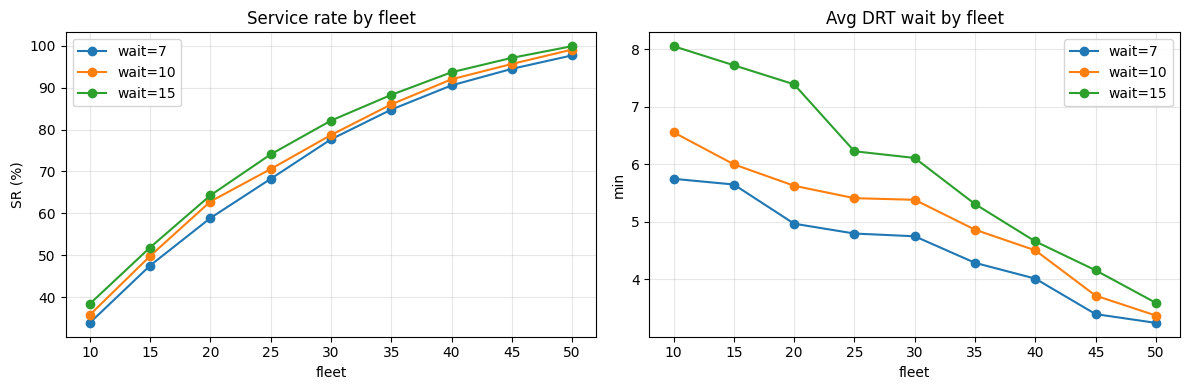

In [2]:
DET_FIX, CAP_FIX, RETRY_FIX = 2.0, 5, 2

df_wait = (
    df_all.query("detour==@DET_FIX and cap==@CAP_FIX and retry==@RETRY_FIX")
          .pivot_table(index="fleet", columns="wait_min",
                       values=["SR(%)","avg_wait_sec"], aggfunc="mean")
)

# 보기 좋게
df_wait.columns = [f"{a} [wait={b}m]" for a,b in df_wait.columns]
df_wait = df_wait.sort_index()
display(df_wait.round(2))

# 저장
p1 = os.path.join(RESULT_DIR, "opt_wait_grid.csv")
df_wait.to_csv(p1, encoding="utf-8-sig")
print("saved:", p1)

# 시각화: 차량대수-성공률 / 차량대수-실제대기
fig, ax = plt.subplots(1,2, figsize=(12,4))
for w, label in [(7,"7m"),(10,"10m"),(15,"15m")]:
    ax[0].plot(df_wait.index, df_wait[f"SR(%) [wait={w}m]"], marker="o", label=f"wait={w}")
    ax[1].plot(df_wait.index, df_wait[f"avg_wait_sec [wait={w}m]"]/60.0, marker="o", label=f"wait={w}")
ax[0].set_title("Service rate by fleet"); ax[0].set_xlabel("fleet"); ax[0].set_ylabel("SR (%)"); ax[0].grid(True, alpha=.3); ax[0].legend()
ax[1].set_title("Avg DRT wait by fleet"); ax[1].set_xlabel("fleet"); ax[1].set_ylabel("min"); ax[1].grid(True, alpha=.3); ax[1].legend()
plt.tight_layout(); plt.show()


,detour,SR(%),avg_wait_sec
78,1.5,79.28,340.08
80,2.0,78.70,322.96
82,2.3,78.48,310.27


saved: C:\dynamic_wirye_drt\results\opt_detour_f30_w10_cap5.csv


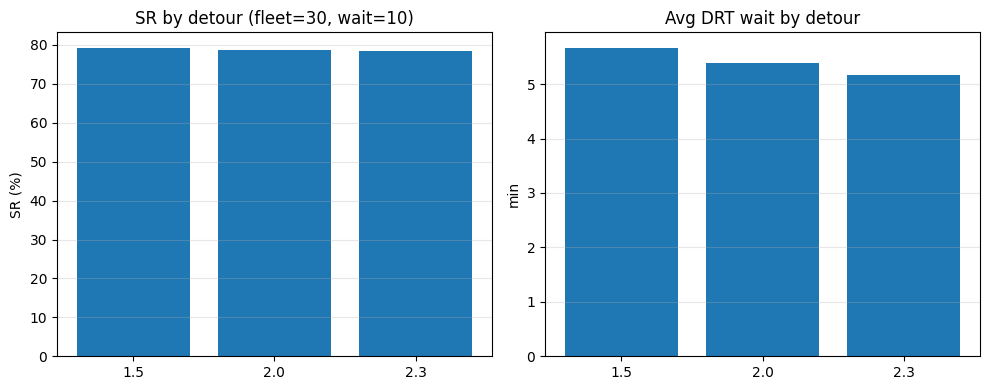

In [3]:
FLEET_FIX, WAIT_FIX, CAP_FIX, RETRY_FIX = 30, 10, 5, 2  # 예: 30대 시나리오 비교

df_det = (
    df_all.query("fleet==@FLEET_FIX and wait_min==@WAIT_FIX and cap==@CAP_FIX and retry==@RETRY_FIX")
          .sort_values("detour")
)

display(df_det[["detour","SR(%)","avg_wait_sec"]].round(2))

# 저장
p2 = os.path.join(RESULT_DIR, f"opt_detour_f{FLEET_FIX}_w{WAIT_FIX}_cap{CAP_FIX}.csv")
df_det.to_csv(p2, index=False, encoding="utf-8-sig"); print("saved:", p2)

# 그래프
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].bar(df_det["detour"].astype(str), df_det["SR(%)"]); ax[0].set_title(f"SR by detour (fleet={FLEET_FIX}, wait={WAIT_FIX})"); ax[0].set_ylabel("SR (%)")
ax[1].bar(df_det["detour"].astype(str), df_det["avg_wait_sec"]/60.0); ax[1].set_title("Avg DRT wait by detour"); ax[1].set_ylabel("min")
for a in ax: a.grid(True, axis="y", alpha=.3)
plt.tight_layout(); plt.show()


,cap,SR(%),avg_wait_sec
80,5,78.70,322.96
81,10,86.38,284.77


saved: C:\dynamic_wirye_drt\results\opt_capacity_f30_w10_dr2.0.csv


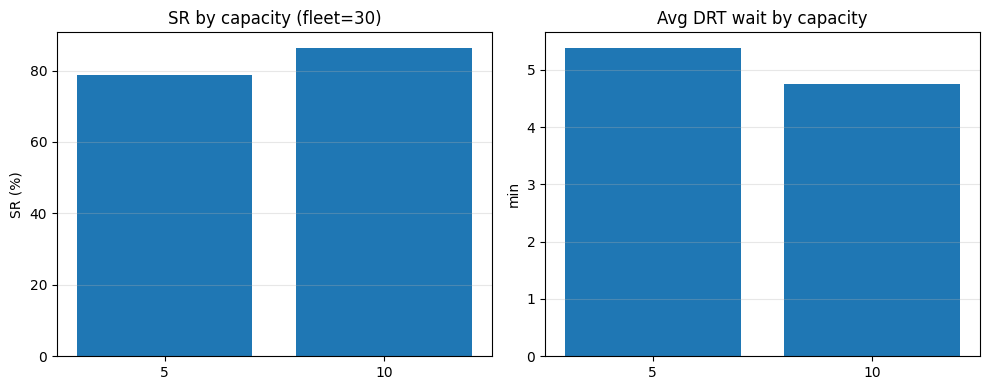

In [4]:
FLEET_FIX, WAIT_FIX, DET_FIX, RETRY_FIX = 30, 10, 2.0, 2

df_cap = (
    df_all.query("fleet==@FLEET_FIX and wait_min==@WAIT_FIX and detour==@DET_FIX and retry==@RETRY_FIX")
          .sort_values("cap")
)

display(df_cap[["cap","SR(%)","avg_wait_sec"]].round(2))

# 저장
p3 = os.path.join(RESULT_DIR, f"opt_capacity_f{FLEET_FIX}_w{WAIT_FIX}_dr{DET_FIX}.csv")
df_cap.to_csv(p3, index=False, encoding="utf-8-sig"); print("saved:", p3)

# 그래프
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].bar(df_cap["cap"].astype(str), df_cap["SR(%)"]); ax[0].set_title(f"SR by capacity (fleet={FLEET_FIX})"); ax[0].set_ylabel("SR (%)")
ax[1].bar(df_cap["cap"].astype(str), df_cap["avg_wait_sec"]/60.0); ax[1].set_title("Avg DRT wait by capacity"); ax[1].set_ylabel("min")
for a in ax: a.grid(True, axis="y", alpha=.3)
plt.tight_layout(); plt.show()


In [5]:
LAMBDA = 2.0  # 대기 1분을 SR 2%p 손실과 동등하게 봄

df_score = df_all.copy()
df_score["avg_wait_min"] = df_score["avg_wait_sec"]/60.0
df_score["score"] = df_score["SR(%)"] - LAMBDA * df_score["avg_wait_min"]

# 예: fleet=30 고정에서 제약조건(대기/우회/정원) 조합 중 최상
best30 = (df_score.query("fleet==30").sort_values("score", ascending=False)
          [["wait_min","detour","cap","SR(%)","avg_wait_min","score"]].head(10))
display(best30.round(2))

# 저장
p4 = os.path.join(RESULT_DIR, "opt_score_top_fleet30.csv")
best30.to_csv(p4, index=False, encoding="utf-8-sig"); print("saved:", p4)


,wait_min,detour,cap,SR(%),avg_wait_min,score
87,15,2.0,10,89.82,5.56,78.70
89,15,2.3,10,89.60,5.68,78.24
83,10,2.3,10,87.34,4.62,78.09
77,7,2.3,10,86.02,4.27,77.47
85,15,1.5,10,88.73,5.85,77.03
81,10,2.0,10,86.38,4.75,76.89
79,10,1.5,10,86.46,4.91,76.64
75,7,2.0,10,84.55,4.07,76.42
73,7,1.5,10,83.60,4.39,74.83
86,15,2.0,5,82.14,6.11,69.92


saved: C:\dynamic_wirye_drt\results\opt_score_top_fleet30.csv
